# Clustering Songs Project

- Are Spotify’s audio features able to identify “similar songs”, as defined by humanly detectable criteria? When you listen to two rock ballads, two operas or two drum & bass songs, you identify them as similar songs. 

- Are these similarities detectable using the audio features from Spotify?

- Is K-Means a good method to create playlists? Would you stick with this algorithm moving forward, or explore other methods to create playlists?

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define all our functions

In [148]:
def get_original_datasource():
    cwd = os.getcwd()
    csv_file = os.path.join(cwd, "df_audio_features_5000.csv")

    raw_df = pd.read_csv(csv_file)
    raw_df = raw_df.rename(columns=lambda x: x.strip())
    raw_df = raw_df.drop(['name', 'artist', 'type', 'html'], axis=1)
    raw_df = raw_df.set_index('id')

    return raw_df

def get_clustered_datasource():
    cwd = os.getcwd()
    csv_file = os.path.join(cwd, "df_audio_features_5000_clustered.csv")

    raw_df = pd.read_csv(csv_file)
    # raw_df.rename(columns={"cluster": "tmp_cluster"}, inplace=True)
    raw_df = raw_df.set_index('id')

    return raw_df

def remove_outliers(df):  
    return df[ (np.abs(scipy.stats.zscore(df)) < 3).all(axis=1) ]

def draw_boxplot(df, title):
    plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.xticks(rotation='vertical')
    sns.boxplot(data=df)
    plt.show()
    
def draw_inertia_plot(df, max_k = 30):
    inertia = []
    min_k = 1
    max_k += 1

    for k in range(min_k, max_k): 
        print("Calculating inertia of K # " + str(k), end='\r')
        inertia.append(KMeans(n_clusters=k).fit(df).inertia_)
        
    print("                                        ", end='\r')
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.title(f'Inertia evolution from 1 cluster to {max_k} clusters')
    sns.lineplot(x=range(min_k, max_k), y=inertia, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

def draw_silouetthe_score(df, max_k=30):
    silhouettes = []
    min_k = 2
    max_k += 1

    for k in range(min_k, max_k): 
        print("Calculating silouetthe score of K # " + str(k), end='\r')
        curr_kmeans = KMeans(n_clusters=k).fit(df)
        silhouettes.append(silhouette_score(df, curr_kmeans.labels_))

    print("                                        ", end='\r')
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.title(f'Silhouette Score evolution from 2 clusters to {max_k} clusters')
    sns.lineplot(x=range(min_k, max_k), y=silhouettes, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

def calc_kmeans(df, num_clusters):
    return KMeans(n_clusters=num_clusters).fit(df)

def get_kmeans_summary(num_clusters, df, df_kmeans):
    return {
        "clusters": num_clusters,
        "inertia": df_kmeans.inertia_,
        "silhouette_score": silhouette_score(df, df_kmeans.labels_),
    }

def predict_clusters(df, df_kmeans):
    clustered_df = df.copy()
    # obtain the cluster output
    clustered_df['cluster'] = df_kmeans.predict(clustered_df)
    centroids_df = pd.DataFrame(df_kmeans.cluster_centers_, columns=df.columns)
    return clustered_df, centroids_df

def draw_heatmap(centroids_df):
    sns.heatmap(centroids_df, cmap="mako")

def draw_scatterplot(clustered_df, centroids_df, xcol, ycol, title = ''):
    plt.subplots(figsize=(12,8))
    plt.title(title)
    sns.scatterplot(data=clustered_df, x=xcol, y=ycol, hue='cluster', palette='Set2')
    sns.scatterplot(data=centroids_df, x=xcol, y=ycol, color='black', s=150)


def print_playlist_samples(clustered_df, num_clusters, samples = 3):
    for cluster in range(0, num_clusters):
        print("Cluster #" + str(cluster) + " song samples: ")
        for id in clustered_df.query('cluster == ' + str(cluster)).sample(samples).index:
            print("https://open.spotify.com/track/"+id)
            # print(clustered_df.loc[clustered_df.index == id].reset_index()[df_columns])
        print("----\n")
        
def analyze_dataset(source_df, cluster_id):
    # import and cleanup
    df = (
        source_df
        .query(f"cluster == {cluster_id}")
        .drop(columns=["cluster"])
    )
    
    # plot distributions
    draw_boxplot(df, 'MinMaxScaler (all dimensions, after removing outliers)')
    
    # find best num of clusters
    draw_inertia_plot(df, 30)
    draw_silouetthe_score(df, 30)
    
    return df
    
def analyze_clusters(df, num_clusters):
    df_kmeans = calc_kmeans(df, num_clusters)
    summary = get_kmeans_summary(num_clusters, df, df_kmeans)
    
    print(summary)
    
    # Predict clusters and centroids
    clustered_df, centroids_df = predict_clusters(df, df_kmeans)
    centroids_df
    
    # Draw clusters heatmap
    draw_heatmap(centroids_df)
    
    return clustered_df, centroids_df
    

# Cluster Analysis

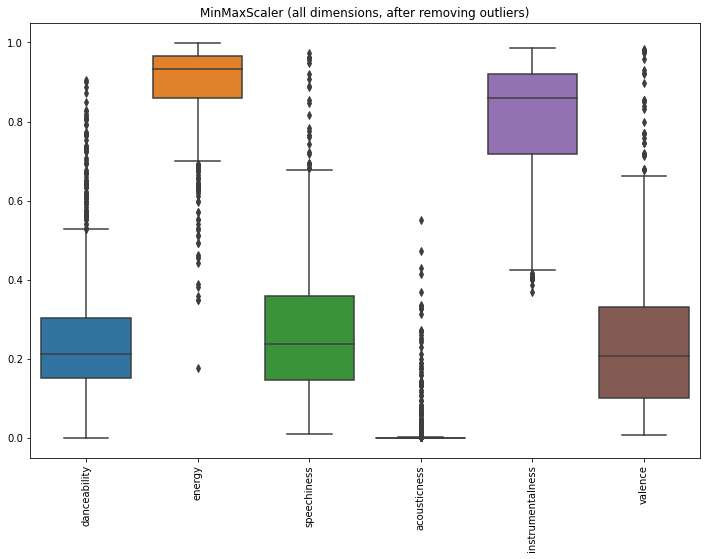

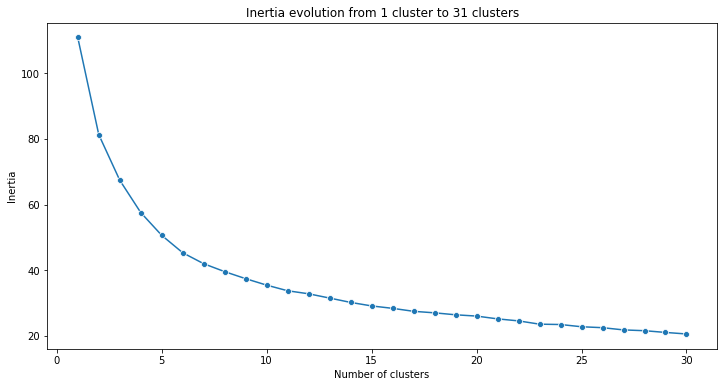

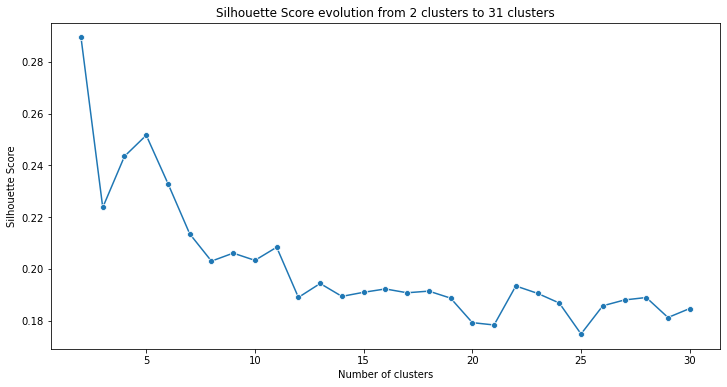

{'clusters': 4, 'inertia': 57.562063436366145, 'silhouette_score': 0.24346121591287045}


(842, 6)

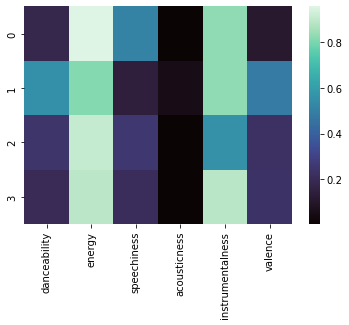

In [149]:
CLUSTER_ID=1
NEW_CLUSTERS=4

df = analyze_dataset(get_clustered_datasource(), CLUSTER_ID)
clustered_df, centroids_df = analyze_clusters(df, NEW_CLUSTERS)
df.shape

# Cluster Prediction

/var/folders/78/qfz58h3s79xcyz3m10xjn8mm0000gn/T/ipykernel_84810/2202684236.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.subplots(figsize=(12,8))


Cluster #0 song samples: 
https://open.spotify.com/track/28PySKvJGGdBwS6AKZ9h5M 
https://open.spotify.com/track/1Ztu0q7qlQyvmLcC8Cm8UM 
https://open.spotify.com/track/4FNu2PuLy904s9dhj2RZ8L 
https://open.spotify.com/track/6LerDRVNtrvvA1aadsfsUd 
----

Cluster #1 song samples: 
https://open.spotify.com/track/4c6vZqYHFur11FbWATIJ9P 
https://open.spotify.com/track/6ho0GyrWZN3mhi9zVRW7xi 
https://open.spotify.com/track/7puypZCFeyJANyN1kfMPP8 
https://open.spotify.com/track/6tW3U7obAotfcyPruXdpM4 
----

Cluster #2 song samples: 
https://open.spotify.com/track/0nFGDLSFEOAEfIh9FPW3DR 
https://open.spotify.com/track/06LoBhsVVxbnGhmWHZhgpf 
https://open.spotify.com/track/52zeJeJrFqKmJBc4FK6767 
https://open.spotify.com/track/217uH0HfiHEngtaoVqh6TV 
----

Cluster #3 song samples: 
https://open.spotify.com/track/1YBsbab9FvYJiTjELEEIYA 
https://open.spotify.com/track/3EjNZuQqmUUuEEM1rXBxcn 
https://open.spotify.com/track/42es8ZJzFiOvjLR1yv0Sn7 
https://open.spotify.com/track/3UhYJQKJAeFAQZw7HUp6W7

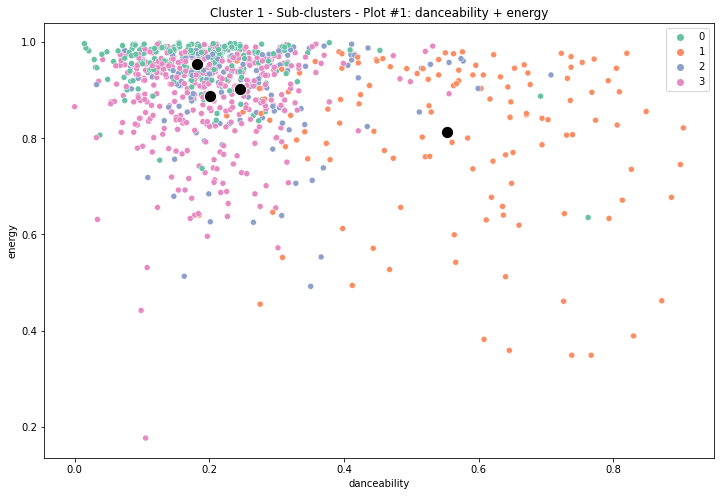

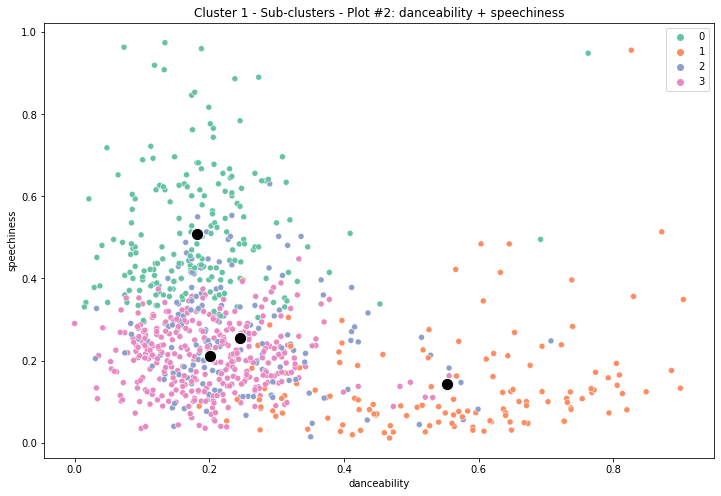

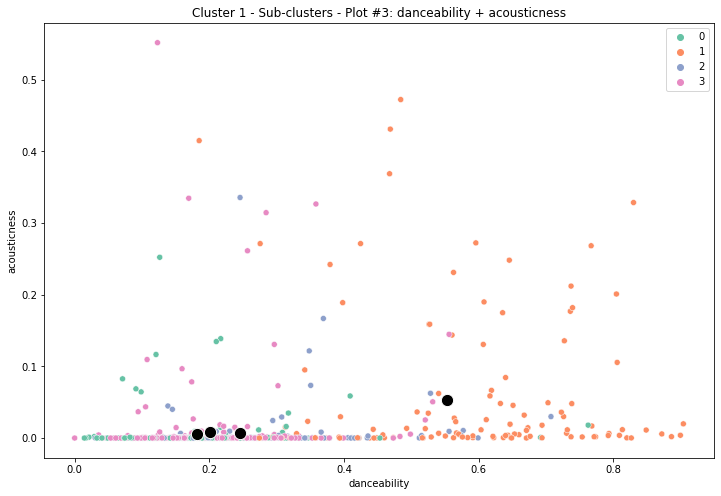

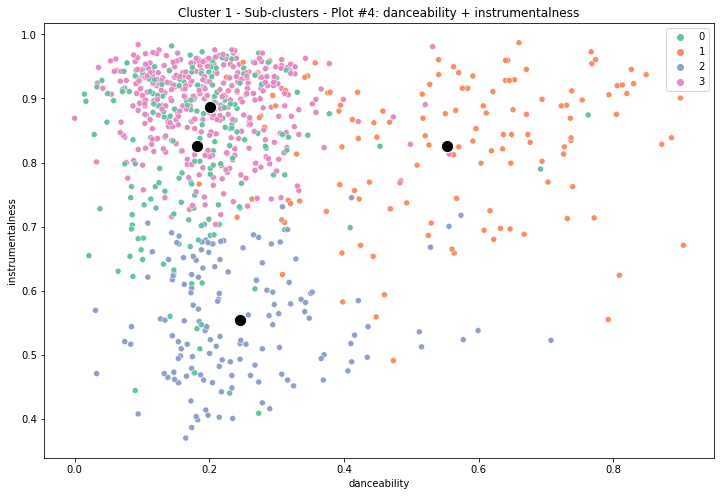

<Figure size 864x576 with 0 Axes>

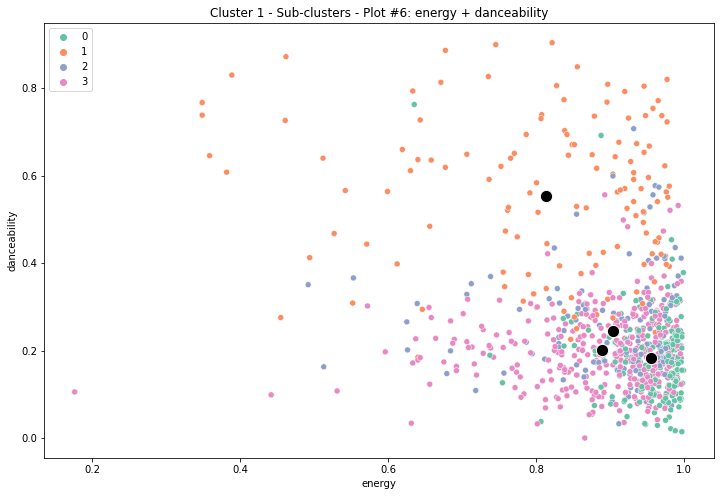

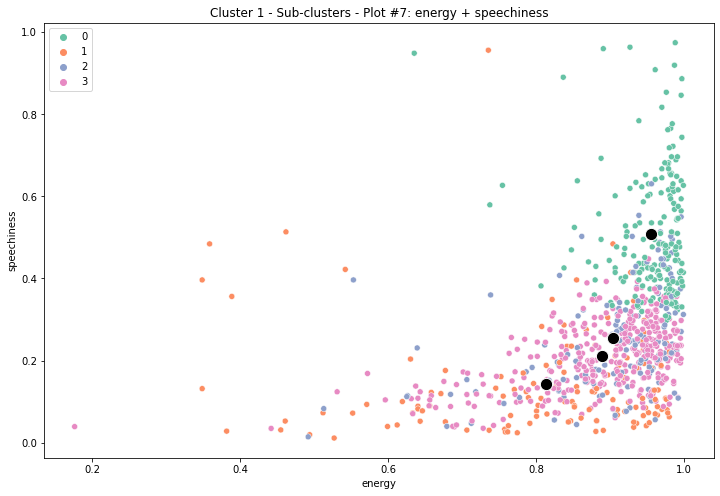

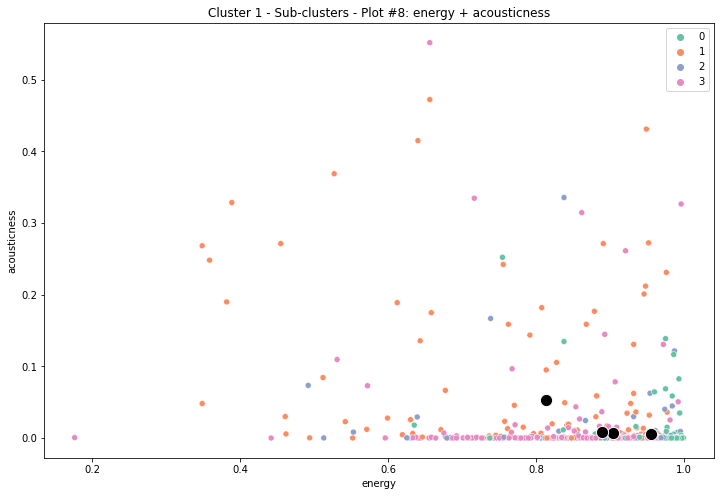

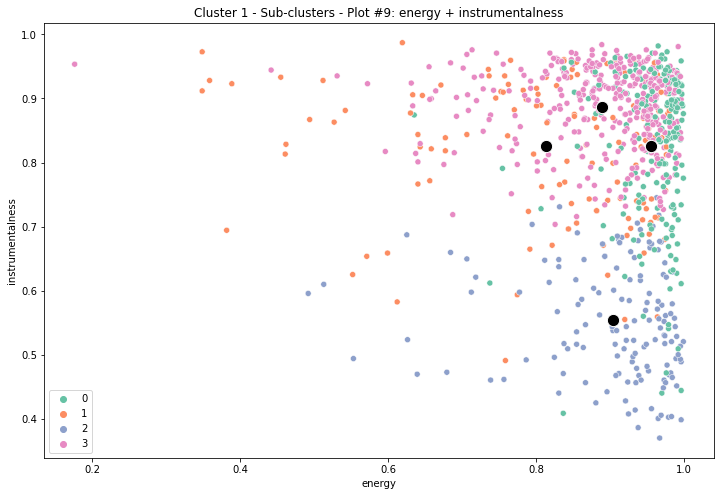

<Figure size 864x576 with 0 Axes>

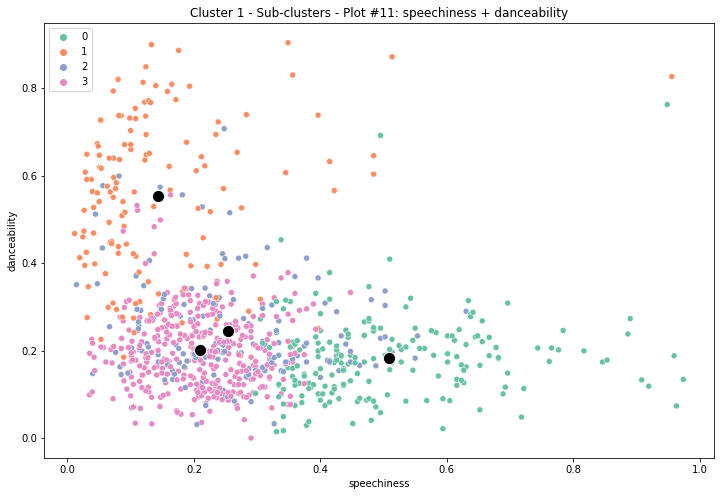

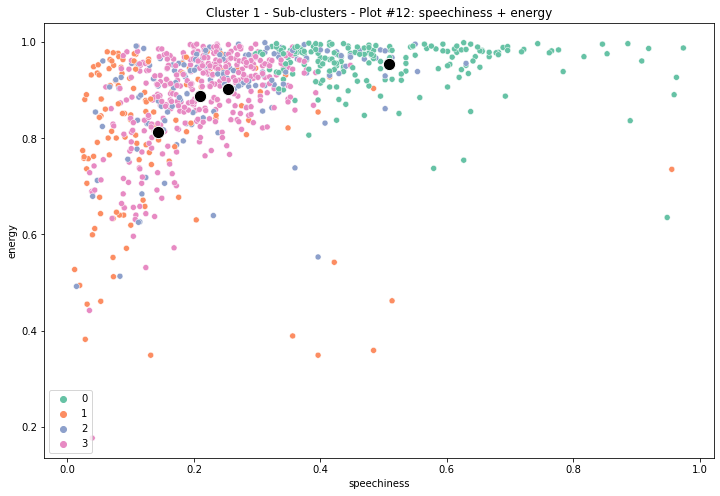

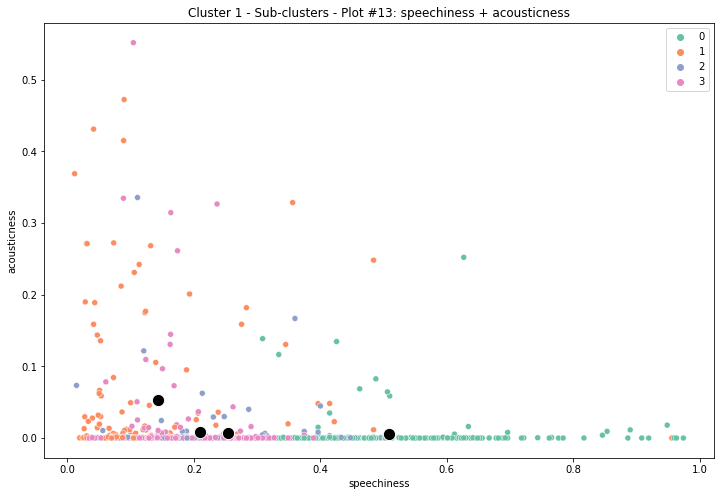

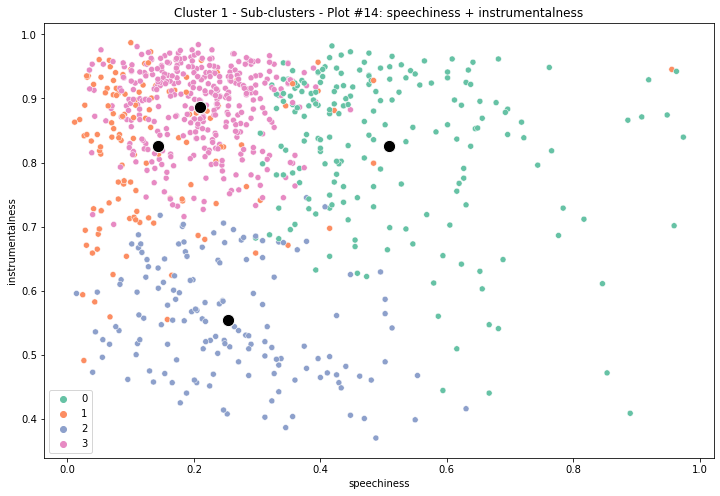

<Figure size 864x576 with 0 Axes>

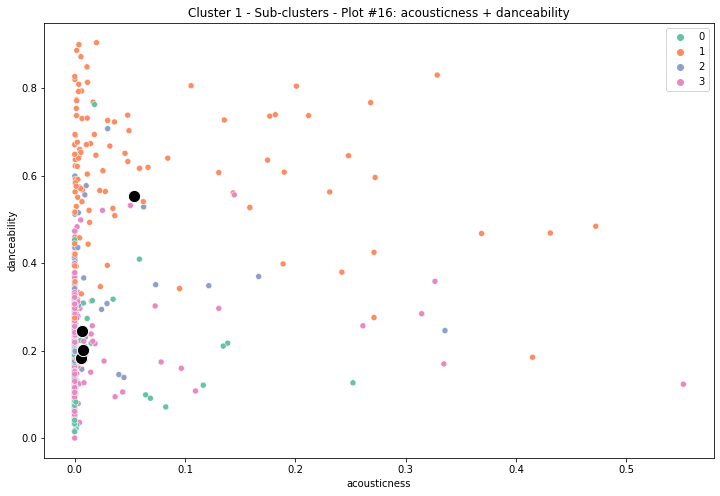

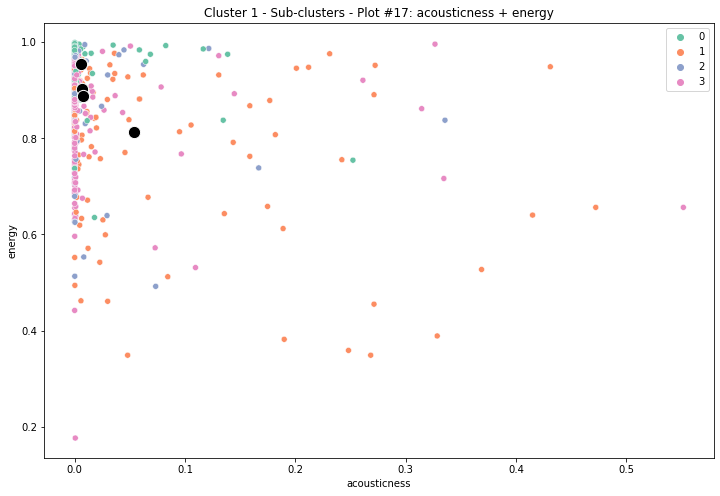

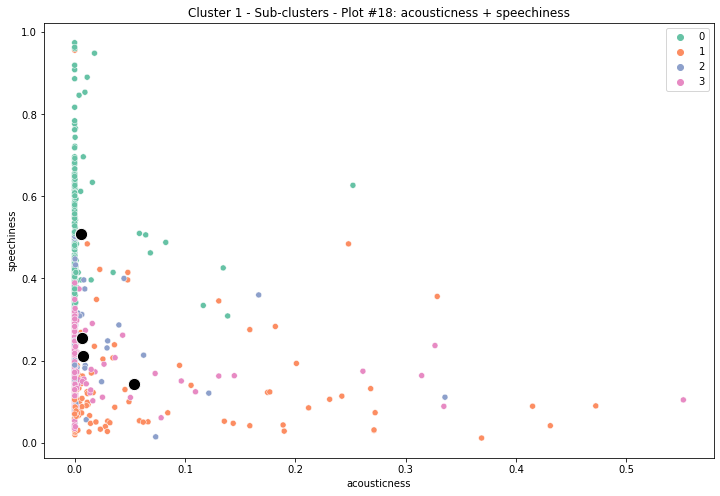

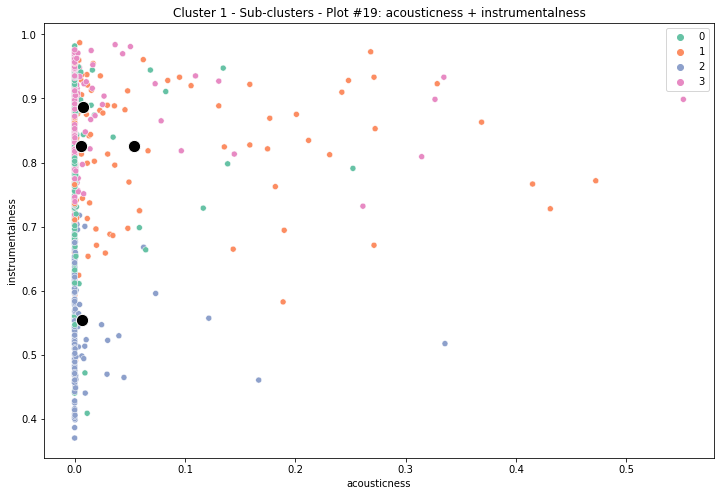

<Figure size 864x576 with 0 Axes>

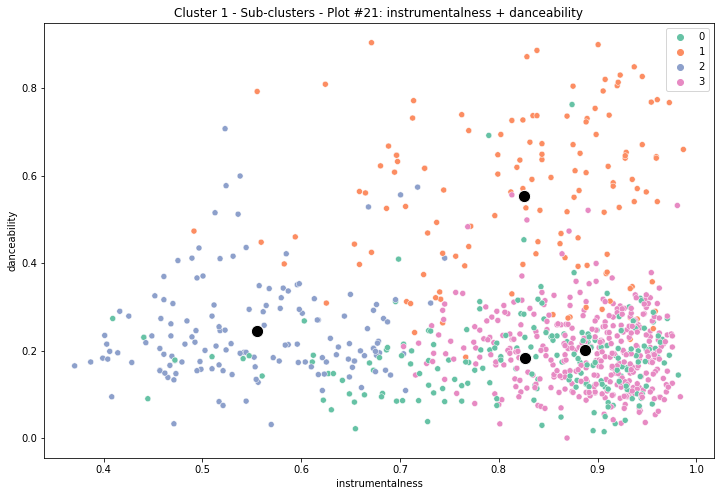

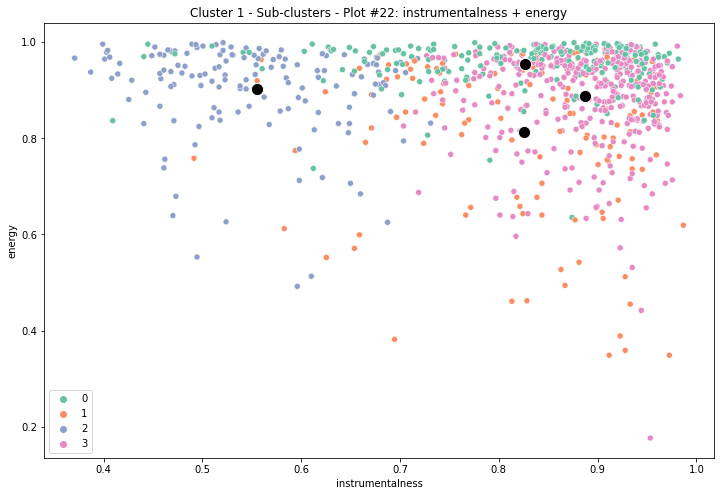

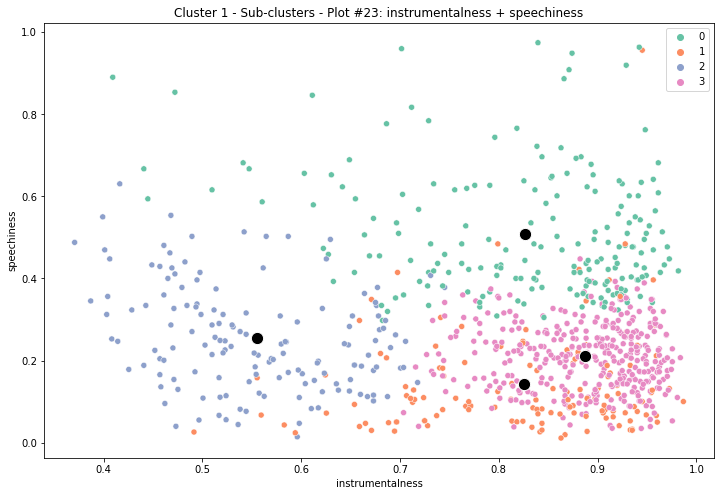

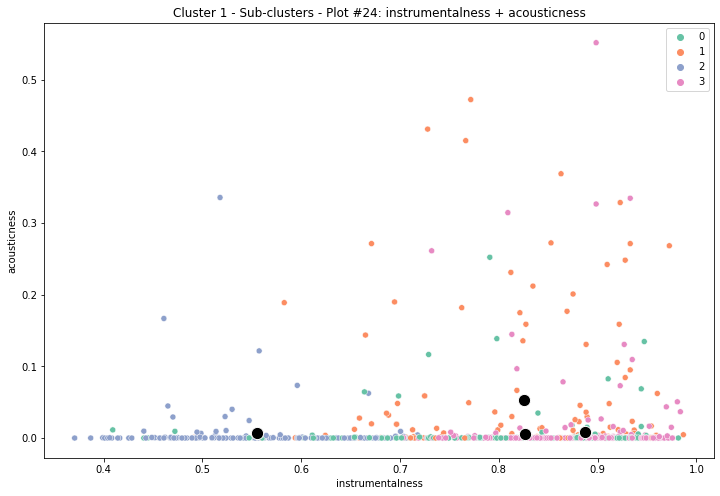

<Figure size 864x576 with 0 Axes>

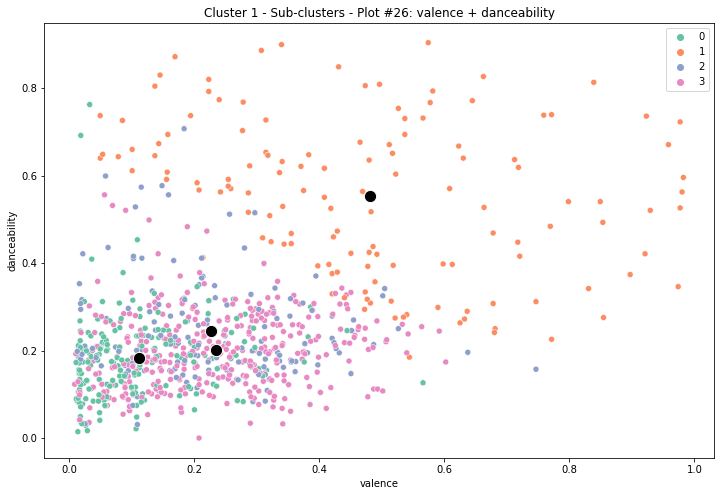

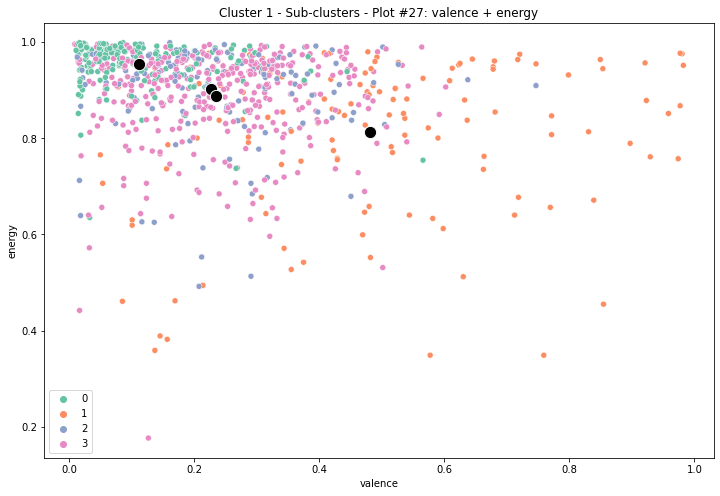

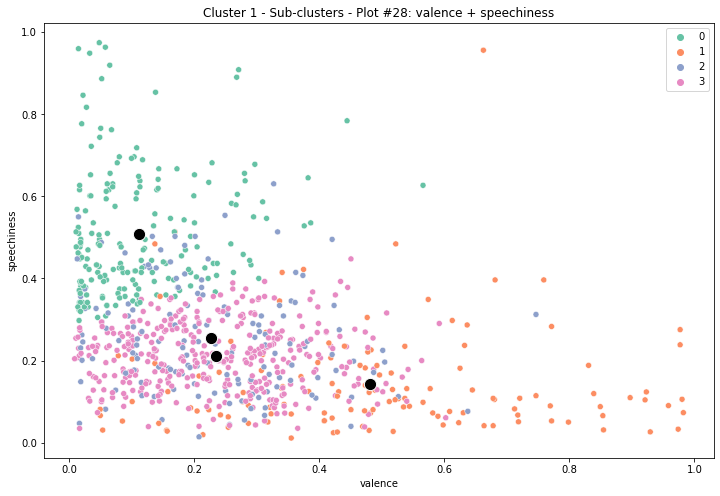

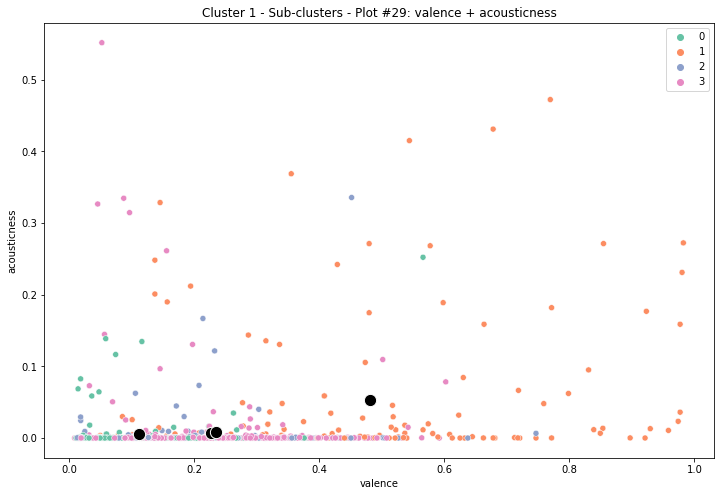

<Figure size 864x576 with 0 Axes>

In [150]:
# ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence']

title = f"Cluster {CLUSTER_ID} - Sub-clusters"
dimensions = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence']

num_plots = 0
for d1 in dimensions:
    for d2 in dimensions:
        if d1 == d2:
            continue
        num_plots+=1
        draw_scatterplot(clustered_df, centroids_df, d1, d2, title + f" - Plot #{num_plots}: {d1} + {d2}")


#draw_scatterplot(clustered_df, centroids_df, "danceability", "energy", title)
#draw_scatterplot(clustered_df, centroids_df, "speechiness", "acousticness", title)
#draw_scatterplot(clustered_df, centroids_df, "instrumentalness", "valence", title)

print_playlist_samples(clustered_df, NEW_CLUSTERS, 4)